In [ ]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score

from xgboost import XGBRegressor, XGBClassifier, LinearRegression

import shap

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt
import utils
import emb

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False
OVERWRITE = False


/Users/ekung/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = dt.get_post_quality_analysis_data()

df = df.loc[df['title'] != 'deleted by author'].reset_index(drop=True)

/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time
/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time


In [3]:
subs = df['subName'].unique().tolist()
sub_embeddings = {}
for sub in subs:
    embedding = np.array(emb.get_embedding_robust(sub))
    embedding = embedding / np.linalg.norm(embedding)
    sub_embeddings[sub] = embedding

In [4]:
title_embeddings = []
text_embeddings = []

for idx, row in df.iterrows():
    title_emb = np.array(emb.get_embedding_robust(row['title']))
    title_emb = title_emb / np.linalg.norm(title_emb)
    title_embeddings.append(title_emb)
    
    text_emb = np.array(emb.get_embedding_robust(row['text']))
    text_emb = text_emb / np.linalg.norm(text_emb)
    text_embeddings.append(text_emb)

title_embeddings = np.array(title_embeddings)
text_embeddings = np.array(text_embeddings)

In [5]:
#for idx, row in df.iterrows():
#    title = row['title']
#    text = row['text']
#    sub = row['subName']
#    
#    title_embedding = np.array(emb.get_embedding_robust(title))
#    title_embedding = title_embedding / np.linalg.norm(title_embedding)
#    
#    text_embedding = np.array(emb.get_embedding_robust(text))
#    text_embedding = text_embedding / np.linalg.norm(text_embedding)#
#
#    title_cos_dist = 1 - np.dot(title_embedding, sub_embeddings[sub])
#    text_cos_dist = 1 - np.dot(text_embedding, sub_embeddings[sub])
#
#    df.at[idx, 'title_cos_dist'] = title_cos_dist
#    df.at[idx, 'text_cos_dist'] = text_cos_dist

In [6]:
emb.close_connections()

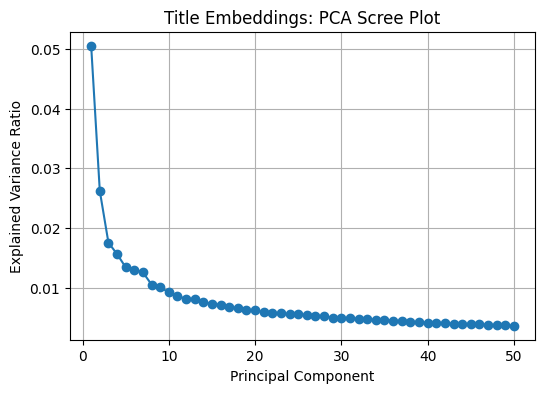

In [7]:
# scree plot for title embeddings
title_pca = PCA()
title_pca.fit(title_embeddings)
explained_variance = title_pca.explained_variance_ratio_[0:50]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Title Embeddings: PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
#filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
#plt.savefig(filename, bbox_inches='tight')
plt.show()



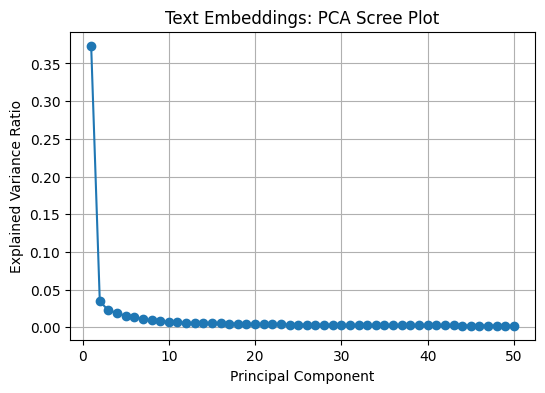

In [8]:
# scree plot for text embeddings
text_pca = PCA()
text_pca.fit(text_embeddings)
explained_variance = text_pca.explained_variance_ratio_[0:50]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Text Embeddings: PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
#filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
#plt.savefig(filename, bbox_inches='tight')
plt.show()



In [9]:
TITLE_PCA_K = 20

title_pca = PCA(n_components=TITLE_PCA_K)
title_pca.fit(title_embeddings)
title_pca_embeddings = title_pca.transform(title_embeddings)

for k in range(TITLE_PCA_K):
    df[f'title_emb_{k}'] = title_pca_embeddings[:, k]

TEXT_PCA_K = 20

text_pca = PCA(n_components=TEXT_PCA_K)
text_pca.fit(text_embeddings)
text_pca_embeddings = text_pca.transform(text_embeddings)

for k in range(TEXT_PCA_K):
    df[f'text_emb_{k}'] = text_pca_embeddings[:, k]

In [10]:
title_emb_cols = [f'title_emb_{k}' for k in range(TITLE_PCA_K)]
text_emb_cols = [f'text_emb_{k}' for k in range(TEXT_PCA_K)]
feature_cols = ['num_words', 'num_img_or_links', 'is_link_post'] + title_emb_cols + text_emb_cols

df['log_sats48'] = np.log1p(df['sats48'])

X = df[feature_cols]
Y = df['log_sats48']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=21
)

In [11]:
model.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

In [29]:
Y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)

print(f"XGB Model")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

XGB Model
RMSE: 1.9017
R2: 0.3469


In [30]:
# OLS model for comparison
from sklearn.linear_model import LinearRegression

ols = LinearRegression(fit_intercept=True)
ols.fit(X, Y)
Y_pred_ols = ols.predict(X)
rmse_ols = np.sqrt(mean_squared_error(Y, Y_pred_ols))
r2_ols = r2_score(Y, Y_pred_ols)

print(f"OLS Model")
print(f"RMSE: {rmse_ols:.4f}")
print(f"R2: {r2_ols:.4f}")

OLS Model
RMSE: 2.1013
R2: 0.2027


In [13]:
feature_importance = pd.Series(
    model.feature_importances_, 
    index=model.feature_names_in_
).sort_values(ascending=False)

fi = feature_importance.rename('importance').reset_index()
fi['feature_group'] = fi['index']
fi.loc[ fi['index'].isin(title_emb_cols), 'feature_group' ] = 'title_embeddings'
fi.loc[ fi['index'].isin(text_emb_cols), 'feature_group' ] = 'text_embeddings'
fi = fi.groupby('feature_group').agg(
    importance = ('importance', 'sum')
).reset_index()

fi


,feature_group,importance
0,is_link_post,0.086927
1,num_img_or_links,0.040290
2,num_words,0.205938
3,text_embeddings,0.446952
4,title_embeddings,0.219893


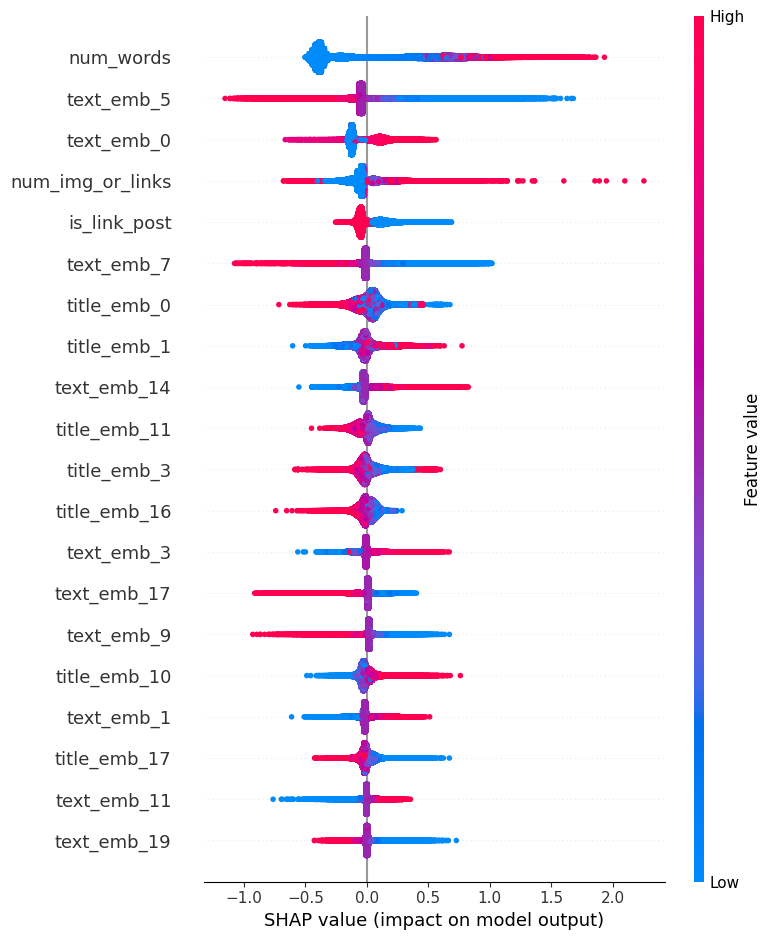

In [14]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

In [15]:
print("Examples with high values of text_emb_5")
print("")

mydf = df.loc[ df['text_emb_5'] > np.quantile(df['text_emb_5'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_5

-------------
Title: HarmonyOS achieved 17 years of Android’s progress in 1 year: Huawei
Territory: tech
URL: https://www.huaweicentral.com/harmonyos-achieved-17-years-of-androids-progress-in-1-year-huawei/

HarmonyOS has made big leaps in progress and completed Android’s 17-year journey in 1 year. Despite numerous challenges in every field, the tech giant is keeping pace with its rivals. HarmonyOS NEXT may touch more new heights after its stable launch.

-------------
Title: US Economy Surges Amid Disinflation
Territory: econ
URL: None

The U.S. economy showcased impressive resilience in Q2 2024, with real GDP accelerating to a robust 3.0% annual growth rate, up from 1.4% in the first quarter. This surge was fueled primarily by a notable increase in consumer spending and gains in private inventory and nonresidential fixed investments. However, this upward momentum faced challenges, as imports, which detract from GDP, also rose, and several key 

In [16]:
(df['sats48']>0).sum()

142501

In [17]:
print("Examples with low values of text_emb_5")
print("")

mydf = df.loc[ df['text_emb_5'] < np.quantile(df['text_emb_5'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_5

-------------
Title: 🧡 Mom asks for advice about son's 'physical' Bitcoin
Territory: bitcoin
URL: None

Mom on Reddit asks Reddit for help regarding her son's 'physical' bitcoin.

Plenty of people pile on with chocolate money jokes.

Thankfully mom gets the right advice in the end.

This was a bit of a rollercoaster - but thankfully a nice one!

![Bitcoin coin](https://external-preview.redd.it/9wy9OQ1E8mNGoJxv_X4QoJX_kfs5gsY7g1VHFO3kq9g.jpg?width=640&crop=smart&auto=webp&v=enabled&s=8a87d2dcd37f62adbe1979400e927ae0c051b1d3)

https://www.reddit.com/r/Bitcoin/comments/149lyz8/i_have_a_physical_bitcoin_how_much_is_it_worth/

-------------
Title: Free Books by Tom Woods
Territory: booksandarticles
URL: https://tomsfreebooks.com/

I just wanted to make this resource known to the SN community.

Tom Woods is an accomplished academic historian and best selling author. He has written about a dozen regular print books on American history, Catholicism, and 

In [18]:
print("Examples with high values of text_emb_0")
print("")

mydf = df.loc[ df['text_emb_0'] > np.quantile(df['text_emb_0'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_0

-------------
Title: 🦡  Bitcoin Emoji Cheat Sheet ⚡
Territory: bitcoin
URL: None

Here's a little list of Bitcoin emojis from [www.blockchaincenter.net](https://www.blockchaincenter.net/crypto-emoji-cheat-sheet/)

⚡	Lightning Network		
🦡	Honeybadger (doesn't care)	
🌋⚒️	Volcano Mining (in El Salvador)		
🆖🆙	NGU, "Number Go Up technology"		
☣️	Toxic Bitcoin Maximalist		
🍕	Bitcoin Pizza Day		
🌈	Rainbow Chart		
🐇🕳️	Bitcoin Rabbit Hole		
💊	Red-pilled
💩	Shitcoin		
💎🙌	"Diamond Hands" = not selling		
🚀	To The Moon		
🐋	Whale, Rich Crypto Holder/Trader				
👀	Look, open your eyes! Probably nothing		
🐂	Permabull		
🐻	Permabear		
🥒	Green Dildo (Chart going up)
🔑	Proof of Keys Movement (withdraw from exchanges)

Source: https://www.blockchaincenter.net/crypto-emoji-cheat-sheet/

(Were more 🍑 I removed the 💩 coin ones!)

-------------
Title: Well, dang, this guy says it's pointless.
Territory: bitcoin
URL: None

I guess we can just pack it in...one guy says, ""B

In [19]:
print("Examples with low values of text_emb_0")
print("")

mydf = df.loc[ df['text_emb_0'] < np.quantile(df['text_emb_0'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_0

-------------
Title: Experience the splendor of Bitcoin ⚡/ Bitcoin Art
Territory: art
URL: None

Thanks for the support ⚡️⚡️⚡️
https://geyser.fund/project/21jclp
IG: https://www.instagram.com/21jclp
Twitter: https://www.twitter.com/21jclp
Nostr: npub1ph8u4tpadanedaauxq986rfmwxadz3tlfe4h97w0fy8pu4tk00jqfup7dv
![](https://m.stacker.news/37240)

-------------
Title: 📺 TFTC #352: Freedom of speech in the digital age with Preston Byrne
Territory: bitcoin
URL: https://www.youtube.com/watch?v=ziyXF6KYSug



-------------
Title: 🎧 Asian diamond hands - Koji Higashi - EP0243 | Connect The World
Territory: bitcoin
URL: https://www.youtube.com/watch?v=mfUZ_F212gA





In [20]:
print("Examples with high values of text_emb_7")
print("")

mydf = df.loc[ df['text_emb_7'] > np.quantile(df['text_emb_7'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_7

-------------
Title: Visiting Home and Being Put to Work!
Territory: photography
URL: None

Living 1,200 miles from home my parents, my mom in particular, loves having me visit because somehow it ends up with me being put to work! Today so far she has had me visit her preschool class and become the butterfly photographer, door holder, recess leader, and even the official counter 😂

![IMG_9797.jpeg](https://m.stacker.news/27691)

![IMG_0642.jpeg](https://m.stacker.news/27688)

![IMG_0643.jpeg](https://m.stacker.news/27690)

I’m not sure I have enough coffee with me to deal with all these kids 😂

-------------
Title: Lightning Network UX challenges & Solutions
Territory: bitcoin
URL: None

![](https://nitter.at/pic/orig/media%2FFzDuklvX0AASWlI.jpg)
By BTCillustrated


-------------
Title: Tulipomania: The First Speculative Bubble in History
Territory: history
URL: None

Tulipomania: The First Speculative Bubble in History

 The tulip fever was a h

In [21]:
print("Examples with low values of text_emb_7")
print("")

mydf = df.loc[ df['text_emb_7'] < np.quantile(df['text_emb_7'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_7

-------------
Title: Some doubts about Relays
Territory: nostr
URL: None

Being connected to more relays is better? , how many relays are you connected to?, do you pay for a relay?


-------------
Title: NATO: Modernization and Global Partnership Plans
Territory: news
URL: None

NATO has announced major initiatives following its latest summit. Key takeaways include:

**Modernizing Nuclear Strategy**: Upgrading nuclear capabilities and enhancing strategic planning.

 **Backing Ukraine's Membership**: Committing to support Ukraine's path towards NATO membership and Euro-Atlantic integration, with continuous support for security and democratic reforms, evaluated annually.

**Invitation to Ukraine**: Extending an invitation to Kiev to join NATO once it meets all necessary conditions.

**Expanding Indo-Pacific Partnerships**: Increasing cooperation with countries in the Indo-Pacific region.

**Defense Spending Goals**: Reaffirming the commitment of me

In [22]:
print("Examples with high values of title_emb_1")
print("")

mydf = df.loc[ df['title_emb_1'] > np.quantile(df['title_emb_1'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')


Examples with high values of title_emb_1

-------------
Title: Which password manager do you use?
Territory: bitcoin
URL: None

-------------
Title: Announcing Envoy Wallet: Bitcoin Simplified
Territory: bitcoin
URL: https://foundationdevices.com/2023/05/announcing-envoy-wallet-bitcoin-simplified/

-------------
Title: Milk Sad: Secure private key generation write up
Territory: bitcoin
URL: https://milksad.info/disclosure.html



In [23]:
print("Examples with low values of title_emb_1")
print("")

mydf = df.loc[ df['title_emb_1'] < np.quantile(df['title_emb_1'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')


Examples with low values of title_emb_1

-------------
Title: JPMorgan about to spend $1 billion on homes in the US, becoming a megalandlord
Territory: bitcoin
URL: https://www.businessinsider.com/jp-morgan-to-acquire-1-billion-of-single-family-rentals-2022-11

-------------
Title: The Borrower on the Other Side of Treasuries is a Deadbeat
Territory: bitcoin
URL: https://tftc.io/martys-bent/the-borrower-on-the-other-side-of-treasuries-is-a-deadbeat/

-------------
Title: Non-Linear Surge in China’s Unemployment: A Recession Looming?
Territory: econ
URL: None



In [27]:
print(f"Diamonds in the rough")
print("")

df['log_sats48_pred'] = Y_pred
df['residual'] = df['log_sats48'] - df['log_sats48_pred']

mydf = df.sort_values(by='residual', ascending=True).head(3).reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"ItemId: {row['itemId']}")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(f"{row['text']}")
    print('')


Diamonds in the rough

-------------
ItemId: 30127
Title: "Crypto currencies are not currencies. They are not. They are not. They are not." -Christine Lagarde President of the European Central Bank
Territory: bitcoin
URL: None

This is a thread on the rubble of a recent paper released by the Swedish central Bank.

Stacker who originally posted the article for our awareness: https://stacker.news/items/30076

The Rubuttal

"Most cryptoassets have so far been used as speculative investments rather than as a means of payment. A reason for this is that they often lack characteristics that we associate with traditional means of payments"

Or you know, because its freaking new

"cryptoassets have low – or no – consumer and investor protection"

My shoes, car, dollars in my wallet, guns in the house, piano, fridgerator etc etc. have no comsumer protection

"and there is a certain degree of anonymity linked to cryptoassets, which means they can be used in illegal transactions."

They've been tr

In [36]:
# Output for regression in R
df_out = df.drop(columns=text_emb_cols + title_emb_cols)
out_filename = os.path.join(DATA_PATH, 'objective_quality_analysis.parquet')
df_out.to_parquet(out_filename, index=False)